In [1]:
# Let's try cleaning up the Y training data to remove peaks we aren't going to predict.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

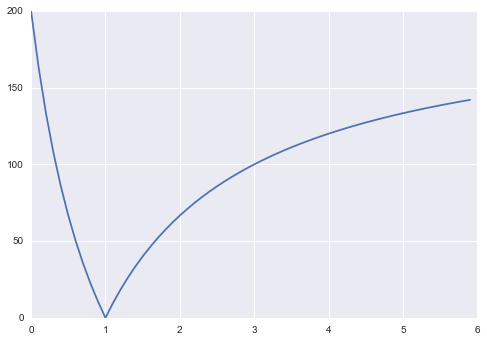

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [117]:
futureT = 64

X_all = all_df.drop(['Page'], axis = 1).values[:, :-futureT]
Y_all = all_df.drop(['Page'], axis = 1).values[:, -futureT:]

In [118]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 486) 	X_valid.shape =  (32074, 486) 	X_test.shape =  (47871, 486)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [8]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result


In [9]:
# Simple tree fit of mean of original data.

model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
print('Smape = ', smape(1e-6 + Y_predict, Y_test))

Smape =  109.999379038


In [10]:
def remove_peaks(Y, proportion = 3.0, niter = 3):
    nSamples, nTimes = Y.shape
    result = Y.copy()
    for i in range(niter):
        means = Y.mean(axis = 1, keepdims = True)
        stds = Y.std(axis = 1, keepdims = True)
        mask = result > (means + proportion * stds)
        for j in range(nSamples):
            result[j][mask[j]] = means[j]
    return result

Y_train2 = remove_peaks(Y_train)
model.fit(X_train, Y_train2)
Y_predict = model.predict(X_valid)
print('smape = ', smape(1e-6 + Y_predict, Y_valid))

smape =  100.15384994


prop =  -1.0 smape =  106.772035118
prop =  -0.9 smape =  106.485779813
prop =  -0.8 smape =  106.152316638
prop =  -0.7 smape =  105.611159402
prop =  -0.6 smape =  105.004046125
prop =  -0.5 smape =  104.247202689
prop =  -0.4 smape =  103.270227429
prop =  -0.3 smape =  101.892127358
prop =  -0.2 smape =  99.3686208272
prop =  -0.1 smape =  94.7130596345
prop =  -2.22044604925e-16 smape =  94.6052075828
prop =  0.1 smape =  94.658251962
prop =  0.2 smape =  94.7657208726
prop =  0.3 smape =  94.8772748012
prop =  0.4 smape =  95.088541297
prop =  0.5 smape =  95.2233062445
prop =  0.6 smape =  95.4256861848
prop =  0.7 smape =  95.6253073218
prop =  0.8 smape =  95.8303731396
prop =  0.9 smape =  96.0679582519


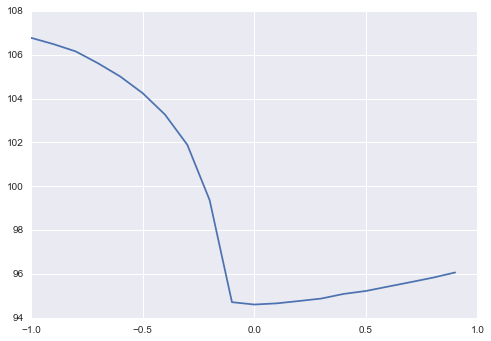

In [73]:
# Do proportion search

proportion_vals = np.arange(-1.0, 1.0, 0.1)
smapes = []
for proportion in proportion_vals:
    Y_train2 = remove_peaks(Y_train, proportion)
    model.fit(X_train, Y_train2)
    Y_predict = model.predict(X_valid)
    newsmape = smape(Y_predict, Y_valid)
    smapes.append(newsmape)
    print('prop = ', proportion, 'smape = ', newsmape)
    
plt.plot(proportion_vals, smapes)
plt.show()

In [74]:
# Do a test

Y_trainvalid2 = remove_peaks(Y_trainvalid, proportion = 0.0)
model.fit(X_trainvalid, Y_trainvalid2)
Y_predict = model.predict(X_trainvalid)
print('smape = ', smape(Y_predict, Y_trainvalid))

smape =  94.1400636568


ps =  20 -0.5  smape =  97.44 ,	ps =  20 -0.3  smape =  99.28 ,	ps =  20 -0.1  smape =  101.08 ,	ps =  20 0.1  smape =  101.11 ,	ps =  20 0.3  smape =  100.93 ,	ps =  40 -0.5  smape =  95.16 ,	ps =  40 -0.3  smape =  96.59 ,	ps =  40 -0.1  smape =  98.04 ,	ps =  40 0.1  smape =  98.07 ,	ps =  40 0.3  smape =  97.92 ,	ps =  60 -0.5  smape =  93.98 ,	ps =  60 -0.3  smape =  95.20 ,	ps =  60 -0.1  smape =  96.34 ,	ps =  60 0.1  smape =  96.36 ,	ps =  60 0.3  smape =  96.21 ,	ps =  80 -0.5  smape =  93.42 ,	ps =  80 -0.3  smape =  94.48 ,	ps =  80 -0.1  smape =  95.49 ,	ps =  80 0.1  smape =  95.51 ,	ps =  80 0.3  smape =  95.38 ,	ps =  100 -0.5  smape =  93.04 ,	ps =  100 -0.3  smape =  93.94 ,	ps =  100 -0.1  smape =  94.66 ,	ps =  100 0.1  smape =  94.68 ,	ps =  100 0.3  smape =  94.56 ,	ps =  120 -0.5  smape =  92.75 ,	ps =  120 -0.3  smape =  93.43 ,	ps =  120 -0.1  smape =  94.14 ,	ps =  120 0.1  smape =  94.16 ,	ps =  120 0.3  smape =  94.05 ,	ps =  140 -0.5  smape =  92.53 ,	ps =  

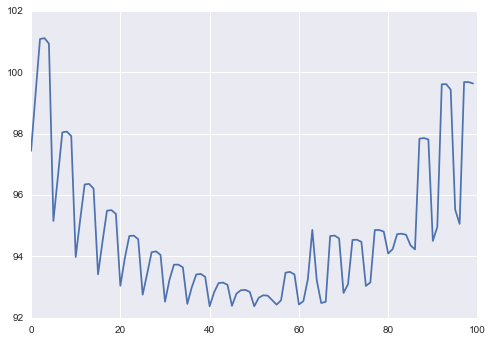

In [11]:
# definition of ztransformation.

def ztransform1(Y, param):
    return 1 / (param + Y)

# inverse transformation, Y = inverseZ(Z)

def inverseZ1(Z, param):
    return -param + 1 / Z

# Values to try for param.

param_search = np.arange(20, 420, 20)
prop_search = np.arange(-0.5, 0.5, 0.2)
search_space = [(x,y) for x in param_search for y in prop_search]

# To record results of fits

smapes = []
epsilon = 1e-6

for param, prop in search_space:
    Y_train2 = remove_peaks(Y_train, proportion = prop)
    Z_train = ztransform1(Y_train2, param)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ1(Z_predict, param)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes.append(newsmape)
    print('ps = ', param, prop, ' smape = ', '%.2f' % newsmape, ',\t', end = '')
    
plt.plot(smapes)
plt.show()

In [41]:
smapes = np.array(smapes)
search_space = np.array(search_space)
print(smapes.shape, search_space.shape)
mask = (smapes < 92.5).reshape(-1)
print(mask.shape)
print(np.hstack((search_space[mask], smapes[mask])) )


(100, 1) (100, 2)
(100,)
[[ 160.           -0.5          92.45375634]
 [ 180.           -0.5          92.37711331]
 [ 200.           -0.5          92.390326  ]
 [ 220.           -0.5          92.3762324 ]
 [ 240.           -0.5          92.42853837]
 [ 260.           -0.5          92.43362566]
 [ 280.           -0.5          92.48045532]]


ps =  100 -0.5  smape =  90.92 ,	ps =  100 -0.3  smape =  92.11 ,	ps =  100 -0.1  smape =  93.99 ,	ps =  100 0.1  smape =  94.02 ,	ps =  100 0.3  smape =  93.86 ,	ps =  300 -0.5  smape =  89.89 ,	ps =  300 -0.3  smape =  90.45 ,	ps =  300 -0.1  smape =  91.91 ,	ps =  300 0.1  smape =  91.95 ,	ps =  300 0.3  smape =  91.79 ,	ps =  500 -0.5  smape =  89.68 ,	ps =  500 -0.3  smape =  89.90 ,	ps =  500 -0.1  smape =  91.21 ,	ps =  500 0.1  smape =  91.23 ,	ps =  500 0.3  smape =  91.10 ,	ps =  700 -0.5  smape =  89.69 ,	ps =  700 -0.3  smape =  89.66 ,	ps =  700 -0.1  smape =  90.68 ,	ps =  700 0.1  smape =  90.71 ,	ps =  700 0.3  smape =  90.57 ,	ps =  900 -0.5  smape =  89.60 ,	ps =  900 -0.3  smape =  89.56 ,	ps =  900 -0.1  smape =  90.48 ,	ps =  900 0.1  smape =  90.48 ,	ps =  900 0.3  smape =  90.35 ,	ps =  1100 -0.5  smape =  89.61 ,	ps =  1100 -0.3  smape =  89.57 ,	ps =  1100 -0.1  smape =  90.23 ,	ps =  1100 0.1  smape =  90.26 ,	ps =  1100 0.3  smape =  90.12 ,	ps =  1300 -0.5  

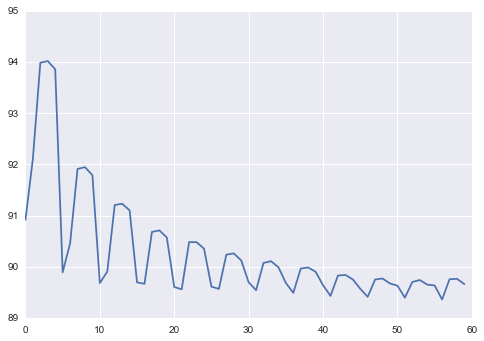

In [42]:
def ztransform2(Y, param):
    return (np.sqrt(Y) - np.sqrt(param)) / np.sqrt(Y + param)

def inverseZ2(Z, param):
    Z2 = np.minimum(Z, 1 - epsilon)
    Z2 = np.maximum(Z2, -1 + epsilon)
    result = -1 - Z2 * np.sqrt(2 - Z2**2)
    result = result / (Z2**2 - 1)
    result = param * result**2
    return result
# Values to try for param.

param_search = np.arange(100, 2500, 200)
prop_search = np.arange(-0.5, 0.5, 0.2)
search_space = [(x,y) for x in param_search for y in prop_search]

# To record results of fits

smapes = []
epsilon = 1e-6

for param, prop in search_space:
    Y_train2 = remove_peaks(Y_train, proportion = prop)
    Z_train = ztransform2(Y_train2, param)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ2(Z_predict, param)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes.append(newsmape)
    print('ps = ', param, prop, ' smape = ', '%.2f' % newsmape, ',\t', end = '')
    
plt.plot(smapes)
plt.show()

In [46]:
smapes = np.array(smapes).reshape(-1,1)
search_space = np.array(search_space)
print(smapes.shape, search_space.shape)
mask = (smapes < 89.5).reshape(-1)
print(mask.shape)
print(np.hstack((search_space[mask], smapes[mask])) )


(60, 1) (60, 2)
(60,)
[[  1.50000000e+03  -3.00000000e-01   8.94875093e+01]
 [  1.70000000e+03  -3.00000000e-01   8.94281100e+01]
 [  1.90000000e+03  -3.00000000e-01   8.94098693e+01]
 [  2.10000000e+03  -3.00000000e-01   8.93935309e+01]
 [  2.30000000e+03  -3.00000000e-01   8.93574013e+01]]


ps =  1 -0.5  smape =  89.89 ,	ps =  51 -0.5  smape =  90.17 ,	ps =  101 -0.5  smape =  91.26 ,	ps =  151 -0.5  smape =  92.00 ,	ps =  201 -0.5  smape =  92.58 ,	ps =  251 -0.5  smape =  93.13 ,	ps =  301 -0.5  smape =  93.56 ,	ps =  351 -0.5  smape =  93.97 ,	ps =  401 -0.5  smape =  94.36 ,	ps =  451 -0.5  smape =  94.66 ,	ps =  1 -0.3  smape =  91.28 ,	ps =  51 -0.3  smape =  90.29 ,	ps =  101 -0.3  smape =  90.94 ,	ps =  151 -0.3  smape =  91.53 ,	ps =  201 -0.3  smape =  92.04 ,	ps =  251 -0.3  smape =  92.39 ,	ps =  301 -0.3  smape =  92.70 ,	ps =  351 -0.3  smape =  93.04 ,	ps =  401 -0.3  smape =  93.37 ,	ps =  451 -0.3  smape =  93.65 ,	ps =  1 -0.1  smape =  93.55 ,	ps =  51 -0.1  smape =  90.47 ,	ps =  101 -0.1  smape =  90.26 ,	ps =  151 -0.1  smape =  90.31 ,	ps =  201 -0.1  smape =  90.35 ,	ps =  251 -0.1  smape =  90.35 ,	ps =  301 -0.1  smape =  90.38 ,	ps =  351 -0.1  smape =  90.48 ,	ps =  401 -0.1  smape =  90.46 ,	ps =  451 -0.1  smape =  90.65 ,	ps =  1 0.1  smape 

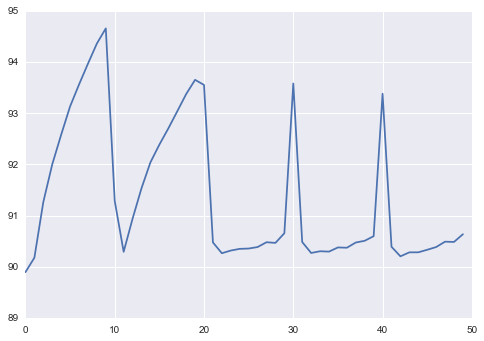

In [152]:
def ztransform3(Y, param):
    return np.log(param + Y)

def inverseZ3(Z, param):
    return -param + np.exp(Z)

# Values to try for param.

param_search = np.arange(1, 500, 50)
prop_search = np.arange(-0.5, 0.5, 0.2)
search_space = [(x,y) for y in prop_search for x in param_search]

# To record results of fits

smapes = []
epsilon = 1e-6

for param, prop in search_space:
    Y_train2 = remove_peaks(Y_train, proportion = prop)
    Z_train = ztransform3(Y_train2, param)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ3(Z_predict, param)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes.append(newsmape)
    print('ps = ', param, prop, ' smape = ', '%.2f' % newsmape, ',\t', end = '')
    
plt.plot(smapes)
plt.show()

In [52]:
smapes = np.array(smapes).reshape(-1,1)
search_space = np.array(search_space)
print(smapes.shape, search_space.shape)
mask = (smapes < 89.5).reshape(-1)
print(mask.shape)
print(np.hstack((search_space[mask], smapes[mask])) )


(100, 1) (100, 2)
(100,)
[[  3.          -0.5         89.43612659]
 [  5.          -0.5         89.2873448 ]
 [  7.          -0.5         89.32613955]
 [  9.          -0.5         89.31903849]
 [ 11.          -0.5         89.30389023]
 [ 13.          -0.5         89.36513525]
 [ 15.          -0.5         89.30681928]
 [ 17.          -0.5         89.34146838]
 [ 19.          -0.5         89.390945  ]
 [ 21.          -0.5         89.44000759]
 [ 23.          -0.5         89.47959662]]


(65118, 16, 4)
(65118, 4)


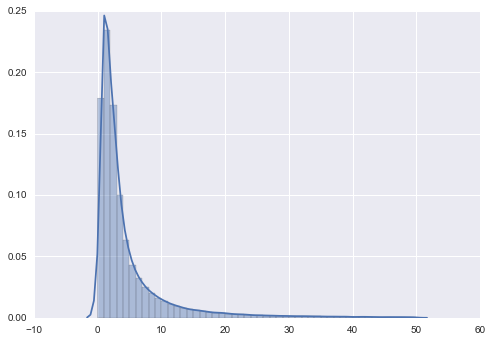

In [83]:
# Let's look at windowing Y_train and look at setting values to minimum inside each window. To decide on the window size, let's
# look at statistics of the ratio window_min / window_max depending on number of windows.

epsilon = 1e-6
nWindows = 4
windowSize = int(64 / nWindows)
Y_train_windows = Y_train [:, np.arange(nWindows) * np.arange(windowSize)[:, np.newaxis]]
print(Y_train_windows.shape)
maxs = np.amax(Y_train_windows, axis = 1)
print(maxs.shape)
mins = np.amin(Y_train_windows, axis = 1)
ratios = maxs / (epsilon + mins)
ratios = ratios.reshape(-1)

sns.distplot(ratios[ratios < 0.5e2])
plt.show()

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 

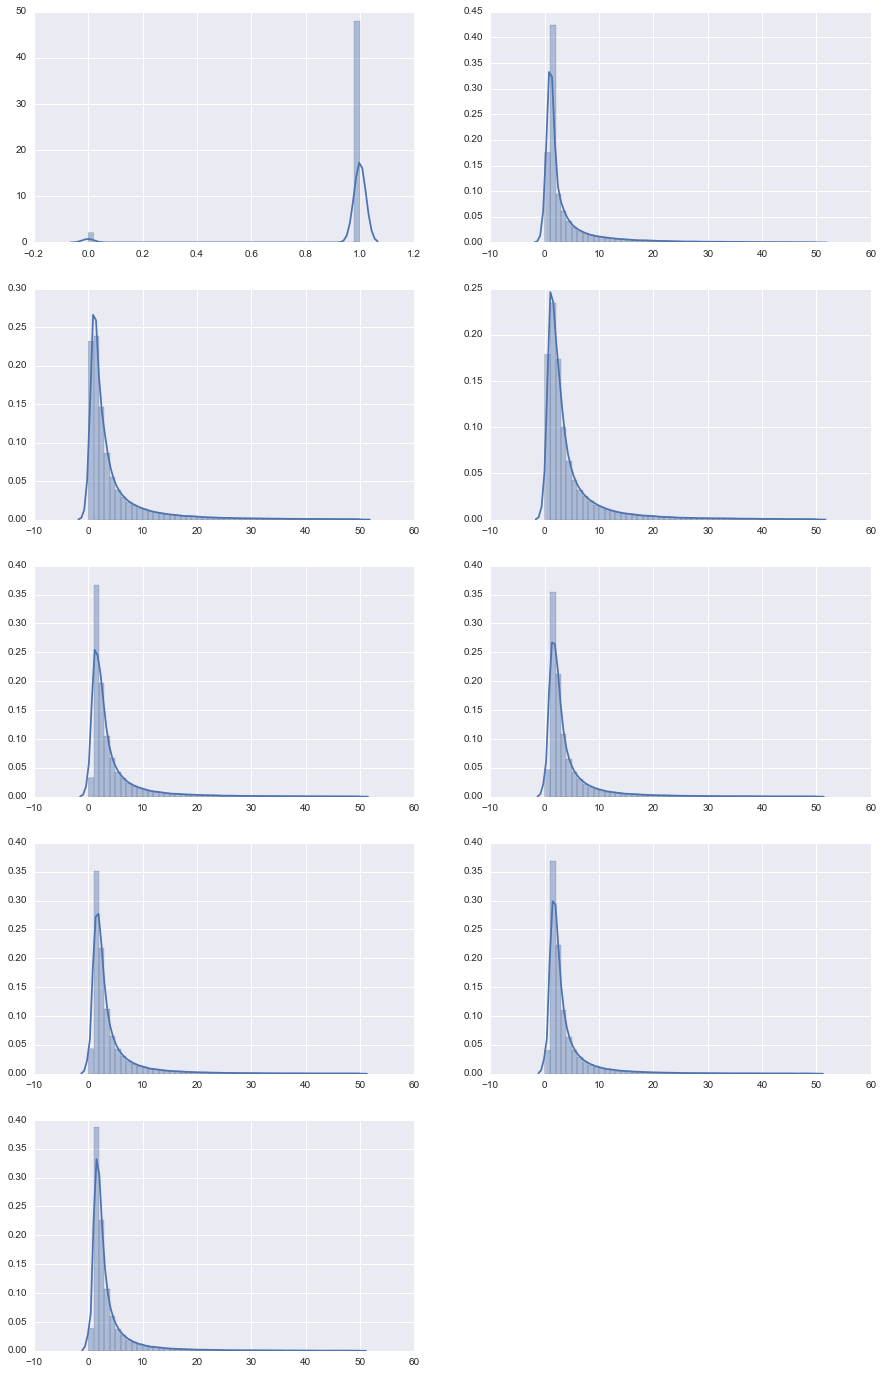

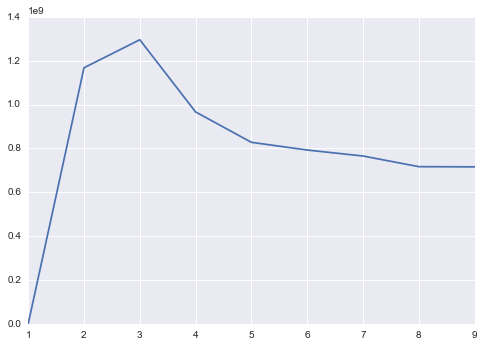

In [99]:
# Let's look at windowing Y_train and look at setting values to minimum inside each window. To decide on the window size, let's
# look at statistics of the ratio window_min / window_max depending on number of windows.

epsilon = 1e-6

plt.figure(figsize = (15, 24))
stds = []
n_search = np.arange(1, 10)
for nWindows in n_search:
    windowSize = int(64 / nWindows)
    Y_train_windows = Y_train [:, np.arange(nWindows) * np.arange(windowSize)[:, np.newaxis]]
    maxs = np.amax(Y_train_windows, axis = 1)
    mins = np.amin(Y_train_windows, axis = 1)
    ratios = maxs / (epsilon + mins)
    ratios = ratios.reshape(-1)
    stds.append(ratios.std())

    plt.subplot(5, 2, nWindows)
    sns.distplot(ratios[ratios < 0.5e2])
    print(nWindows, ', ', end = '')
plt.show()

plt.plot(n_search, stds)
plt.show()

In [135]:
# Now try replacing values inside Y_train windows with window minimum.

def window_mins(Y, nWindows = 8):
    nSamples, nTimes = Y.shape
    Y2 = Y.copy()
    windowSize = int(nTimes / nWindows)
    
    cols = np.arange(windowSize)[:, np.newaxis] + windowSize * np.arange(nWindows)
    Y_windows = Y[:, cols]
    mins = np.amin(Y_windows, axis = 1, keepdims = True)
    Y2[:, cols] = mins
    return Y2

def window_prop(Y, nWindows = 8, prop = 0.95):
    nSamples, nTimes = Y.shape
    Y2 = Y.copy()
    windowSize = int(nTimes / nWindows)
    
    cols = np.arange(windowSize)[:, np.newaxis] + windowSize * np.arange(nWindows)
    Y_windows = Y[:, cols]
    mins = np.amin(Y_windows, axis = 1, keepdims = True)
    maxs = np.amax(Y_windows, axis = 1, keepdims = True)
    Y2[:, cols] = prop * mins + (1 - prop) * maxs
    return Y2

Y_train2 = window_mins(Y_train)
model.fit(X_train, Y_train2)
Y_predict = model.predict(X_valid)
print('smape = ', smape(Y_predict, Y_valid))

Y_train2 = window_prop(Y_train)
model.fit(X_train, Y_train2)
Y_predict = model.predict(X_valid)
print('smape = ', smape(Y_predict, Y_valid))

smape =  94.8722781206
smape =  95.801805104


prop =  0.95 smape =  95.80
prop =  0.9525 smape =  95.66
prop =  0.955 smape =  95.49
prop =  0.9575 smape =  95.33
prop =  0.96 smape =  95.16
prop =  0.9625 smape =  95.00
prop =  0.965 smape =  94.89
prop =  0.9675 smape =  94.74
prop =  0.97 smape =  94.59
prop =  0.9725 smape =  95.87
prop =  0.975 smape =  95.76
prop =  0.9775 smape =  95.54
prop =  0.98 smape =  95.44
prop =  0.9825 smape =  95.34
prop =  0.985 smape =  95.26
prop =  0.9875 smape =  95.17
prop =  0.99 smape =  95.09
prop =  0.9925 smape =  95.03
prop =  0.995 smape =  94.97
prop =  0.9975 smape =  94.92
prop =  1.0 smape =  94.87


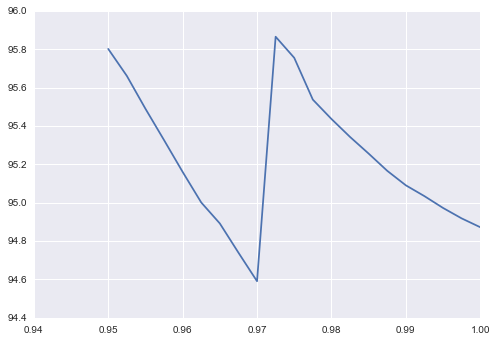

In [142]:
# Let's do a search on proportion.

prop_search = np.arange(0.95, 1.0, 0.0025)
#prop_search = np.arange(0.0, 1.0, 0.05)
#prop_search = np.arange(0.0, 2.0, 0.1)
smapes = []
for prop in prop_search:
    
    Y_train2 = window_prop(Y_train, prop = prop)
    model.fit(X_train, Y_train2)
    Y_predict = model.predict(X_valid)
    newsmape = smape(Y_predict, Y_valid)
    print('prop = ', prop, 'smape = ', '%.2f' % newsmape)
    smapes.append(newsmape)
    
plt.plot(prop_search, smapes)
plt.show()

ps =  20  smape =  114.12 ,	ps =  40  smape =  109.36 ,	ps =  60  smape =  106.92 ,	ps =  80  smape =  105.26 ,	ps =  100  smape =  103.86 ,	ps =  120  smape =  102.85 ,	ps =  140  smape =  102.01 ,	ps =  160  smape =  101.36 ,	ps =  180  smape =  100.84 ,	ps =  200  smape =  100.50 ,	ps =  220  smape =  100.44 ,	ps =  240  smape =  100.28 ,	ps =  260  smape =  101.21 ,	ps =  280  smape =  100.93 ,	ps =  300  smape =  100.95 ,	ps =  320  smape =  100.79 ,	ps =  340  smape =  100.85 ,	ps =  360  smape =  103.86 ,	ps =  380  smape =  103.71 ,	ps =  400  smape =  104.05 ,	

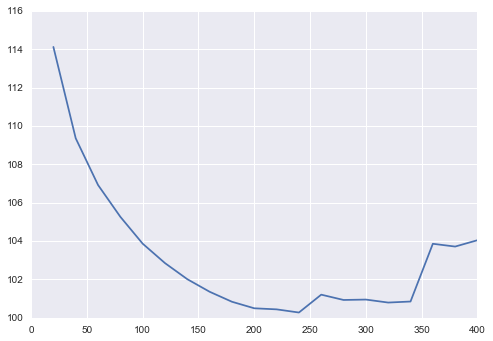

In [144]:
# definition of ztransformation.

def ztransform1(Y, param):
    return 1 / (param + Y)

# inverse transformation, Y = inverseZ(Z)

def inverseZ1(Z, param):
    return -param + 1 / Z

# Values to try for param.

param_search = np.arange(20, 420, 20)

# To record results of fits

smapes = []
epsilon = 1e-6

for param in param_search:
    Y_train2 = window_mins(Y_train, nWindows = 8)
    Z_train = ztransform1(Y_train2, param)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ1(Z_predict, param)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes.append(newsmape)
    print('ps = ', param, ' smape = ', '%.2f' % newsmape, ',\t', end = '')
    
plt.plot(param_search, smapes)
plt.show()

ps =  100  smape =  107.59 ,	ps =  600  smape =  102.76 ,	ps =  1100  smape =  101.62 ,	ps =  1600  smape =  101.17 ,	ps =  2100  smape =  100.88 ,	ps =  2600  smape =  100.63 ,	ps =  3100  smape =  100.47 ,	ps =  3600  smape =  100.38 ,	ps =  4100  smape =  100.32 ,	ps =  4600  smape =  100.26 ,	

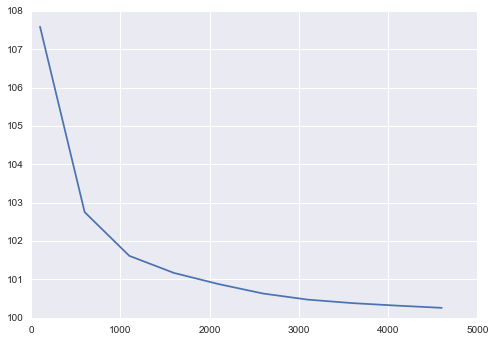

In [147]:
# Try z transformation 2
param_search = np.arange(100, 5000, 500)

# To record results of fits

smapes = []
epsilon = 1e-6

for param in param_search:
    Y_train2 = window_mins(Y_train, nWindows = 8)
    Z_train = ztransform2(Y_train2, param)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ2(Z_predict, param)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes.append(newsmape)
    print('ps = ', param, ' smape = ', '%.2f' % newsmape, ',\t', end = '')
    
plt.plot(param_search, smapes)
plt.show()

ps =  1  smape =  107.68 ,	ps =  51  smape =  97.87 ,	ps =  101  smape =  96.18 ,	ps =  151  smape =  95.29 ,	ps =  201  smape =  94.58 ,	ps =  251  smape =  94.21 ,	ps =  301  smape =  93.90 ,	ps =  351  smape =  93.66 ,	ps =  401  smape =  93.44 ,	ps =  451  smape =  93.26 ,	ps =  501  smape =  93.21 ,	ps =  551  smape =  93.05 ,	ps =  601  smape =  92.90 ,	ps =  651  smape =  92.79 ,	ps =  701  smape =  92.75 ,	

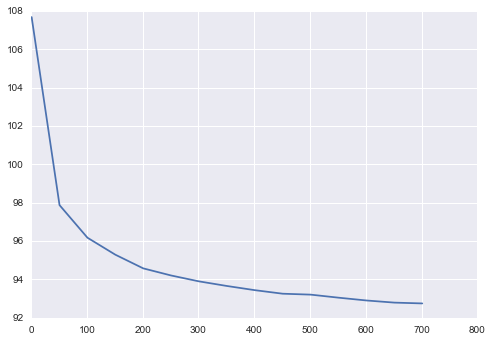

In [151]:
# Try z transformation 3
param_search = np.arange(1, 750, 50)

# To record results of fits

smapes = []
epsilon = 1e-6

for param in param_search:
    Y_train2 = window_mins(Y_train, nWindows = 8)
    Z_train = ztransform3(Y_train2, param)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ3(Z_predict, param)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes.append(newsmape)
    print('ps = ', param, ' smape = ', '%.2f' % newsmape, ',\t', end = '')
    
plt.plot(param_search, smapes)
plt.show()